In [21]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format='retina'

from __future__ import absolute_import, division ,print_function

import sys
import os

import pandas as pd
import numpy as np

import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.tsa.api as smt

import matplotlib.pylab as plt
import seaborn as sns

pd.set_option('display.float_format',lambda x: '%.5f'%x)
np.set_printoptions(precision=5,suppress=True)

pd.set_option('display.max_columns',100)
pd.set_option('display.max_rows',100)

sns.set(style='ticks',context='poster')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [22]:
ts_df=pd.read_csv(r'C:\Users\Ordinary\Desktop\sentiment.csv',index_col=0
                      ,parse_dates=[0])
n_sample=ts_df.shape[0]

In [23]:
print(ts_df.shape)
print(ts_df.head())

(100, 1)
              value
date               
2016-01-01 -0.15473
2016-01-02 -0.25446
2016-01-03 -0.11101
2016-01-04 -0.93369
2016-01-05  0.76727


In [24]:
n_train=int(0.95*n_sample)+1
n_forcecast=n_sample-n_train

ts_train=ts_df.iloc[:n_train]['value']
ts_test=ts_df.iloc[n_train:]['value']
print(ts_train.shape)
print(ts_test.shape)
print('Training Series:','\n',ts_train.tail(),'\n')
print('Testing Series:','\n',ts_test.head())

(96,)
(4,)
Training Series: 
 date
2016-04-01    1.20279
2016-04-02    0.94073
2016-04-03    1.09862
2016-04-04   -0.54182
2016-04-05   -2.03231
Name: value, dtype: float64 

Testing Series: 
 date
2016-04-06    1.08072
2016-04-07   -0.90121
2016-04-08   -0.97039
2016-04-09   -0.68633
Name: value, dtype: float64


In [29]:
def tsplot(y,lags=None,title='',figsize=(14,8)):
    fig=plt.figure(figsize=figsize)
    layout=(2,2)
    ts_ax=plt.subplot2grid(layout,(0,0))
    hist_ax=plt.subplot2grid(layout,(0,1))
    acf_ax=plt.subplot2grid(layout,(1,0))
    pacf_ax=plt.subplot2grid(layout,(1,1))
    
    y.plot(ax=ts_ax)
    ts_ax.set_title(title)
    y.plot(ax=hist_ax,kind='hist',bins=25)
    hist_ax.set_title('Histogram')
    smt.graphics.plot_acf(y,lags=lags,ax=acf_ax)
    smt.graphics.plot_pacf(y,lags=lags,ax=pacf_ax)
    [ax.set_xlim(0) for ax in [acf_ax,pacf_ax]]
    sns.despine()
    plt.tight_layout()
    return ts_ax,acf_ax,pacf_ax

(<matplotlib.axes._subplots.AxesSubplot at 0x2a87044f550>,
 <matplotlib.axes._subplots.AxesSubplot at 0x2a8704f5d30>)

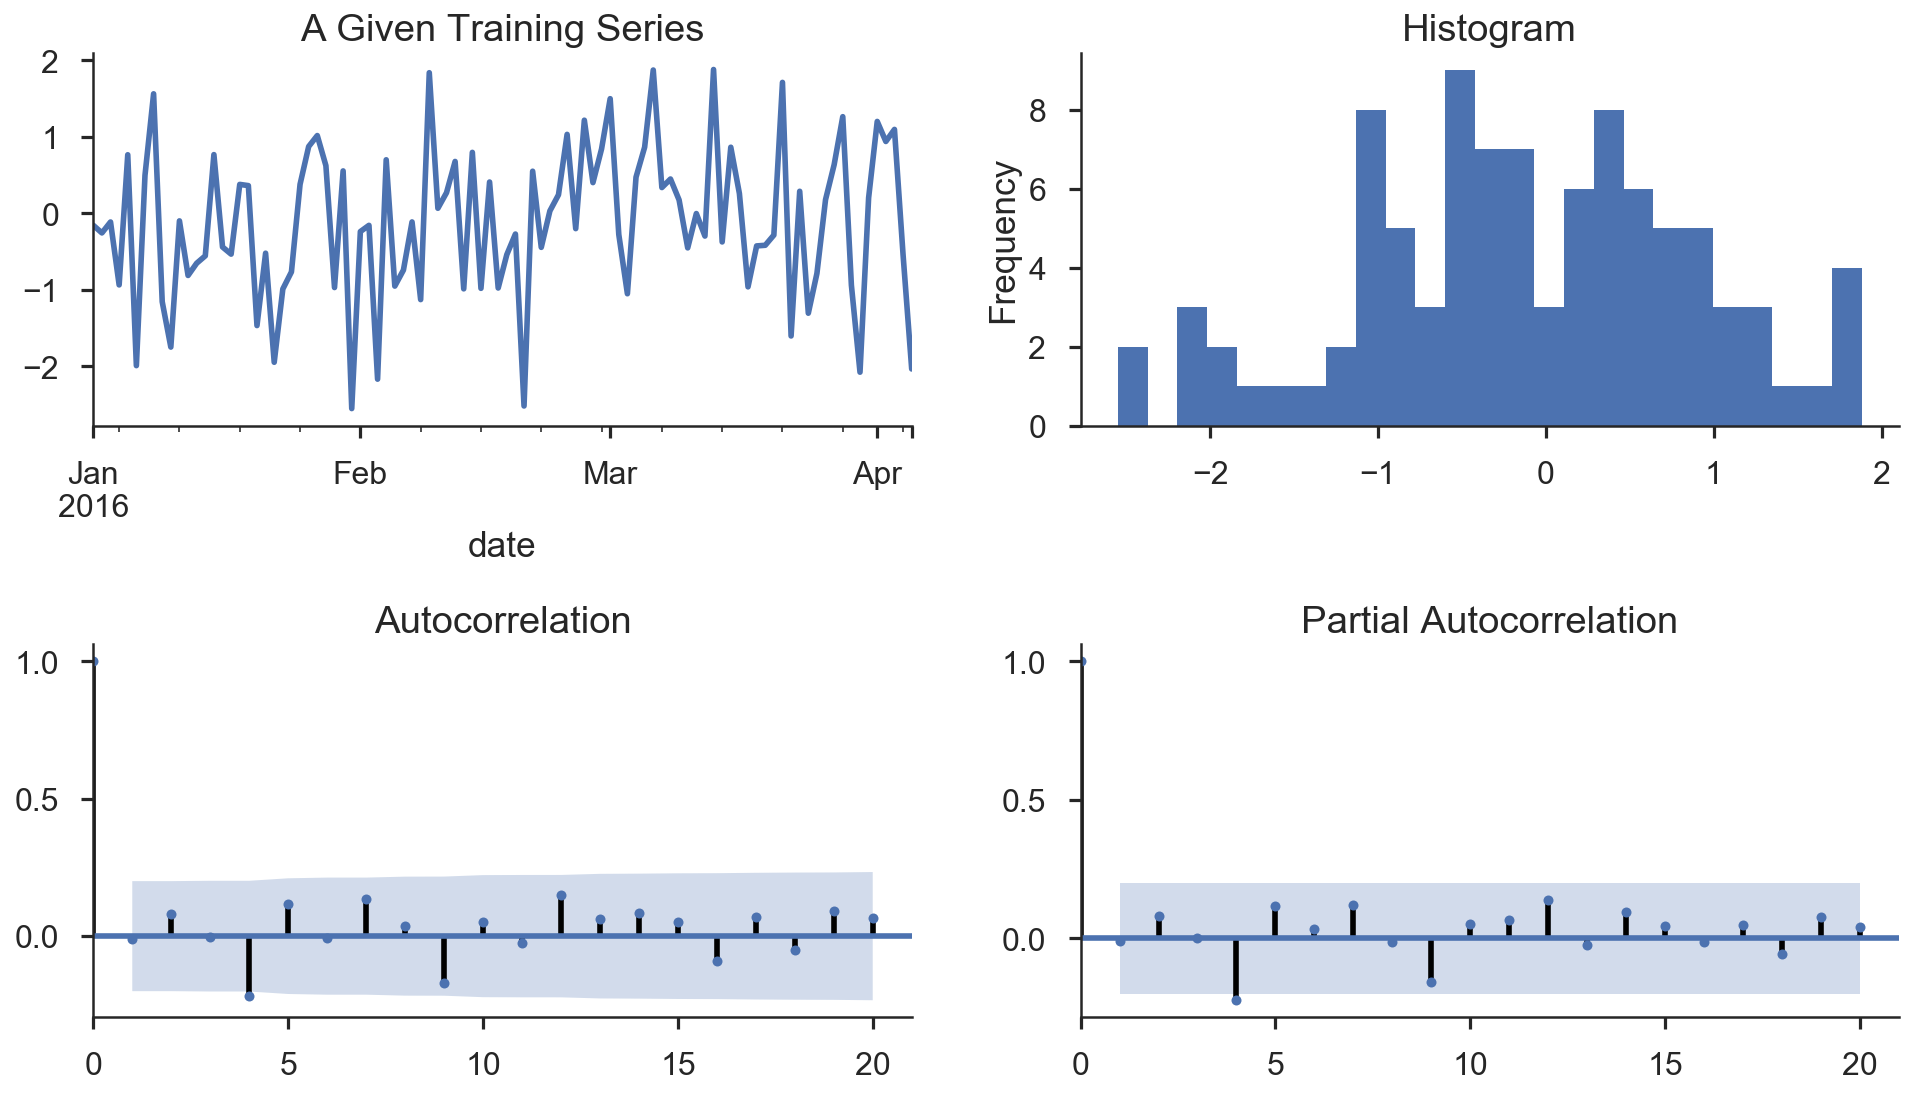

In [30]:
tsplot(ts_train,title='A Given Training Series',lags=20)

In [32]:
arima200=sm.tsa.SARIMAX(ts_train,order=(2,0,0))
model_results=arima200.fit()

In [41]:
import itertools

p_min=0
d_min=0
q_min=0
p_max=4
d_max=0
q_max=4

results_bic=pd.DataFrame(index=['AR{}'.format(i) for i in range(p_min,p_max+1)],
                        columns=['MA{}'.format(i) for i in range(q_min,q_max+1)])

for p,d,q in itertools.product(range(p_min,p_max+1),
                               range(d_min,d_max+1),
                                range(q_min,q_max+1)):
    if p==0 and d==0 and q==0:
        results_bic.loc['AR{}'.format(p),'MA{}'.format(q)]=np.nan
        continue
    try:
        model =sm.tsa.SARTMAX(ts_train,order=(p,d,q))
        results=model.fit()
        results_bic.loc['AR{}'.format(p),'MA{}'.format(q)]=results.bic
    except:
        continue
results_bic=results_bic[results_bic.columns].astype(float)

     MA0  MA1  MA2  MA3  MA4
AR0  nan  nan  nan  nan  nan
AR1  nan  nan  nan  nan  nan
AR2  nan  nan  nan  nan  nan
AR3  nan  nan  nan  nan  nan
AR4  nan  nan  nan  nan  nan
[[ 0.04324  0.89962  0.61063  0.38144  0.27712]
 [ 0.73536  0.01542  0.93339  0.48221  0.83987]
 [ 0.91184  0.83917  0.04208  0.85727  0.32333]
 [ 0.30436  0.94645  0.73323  0.92355  0.97249]
 [ 0.47328  0.76345  0.309    0.88852  0.26313]]


Text(0.5,1,'BIC')

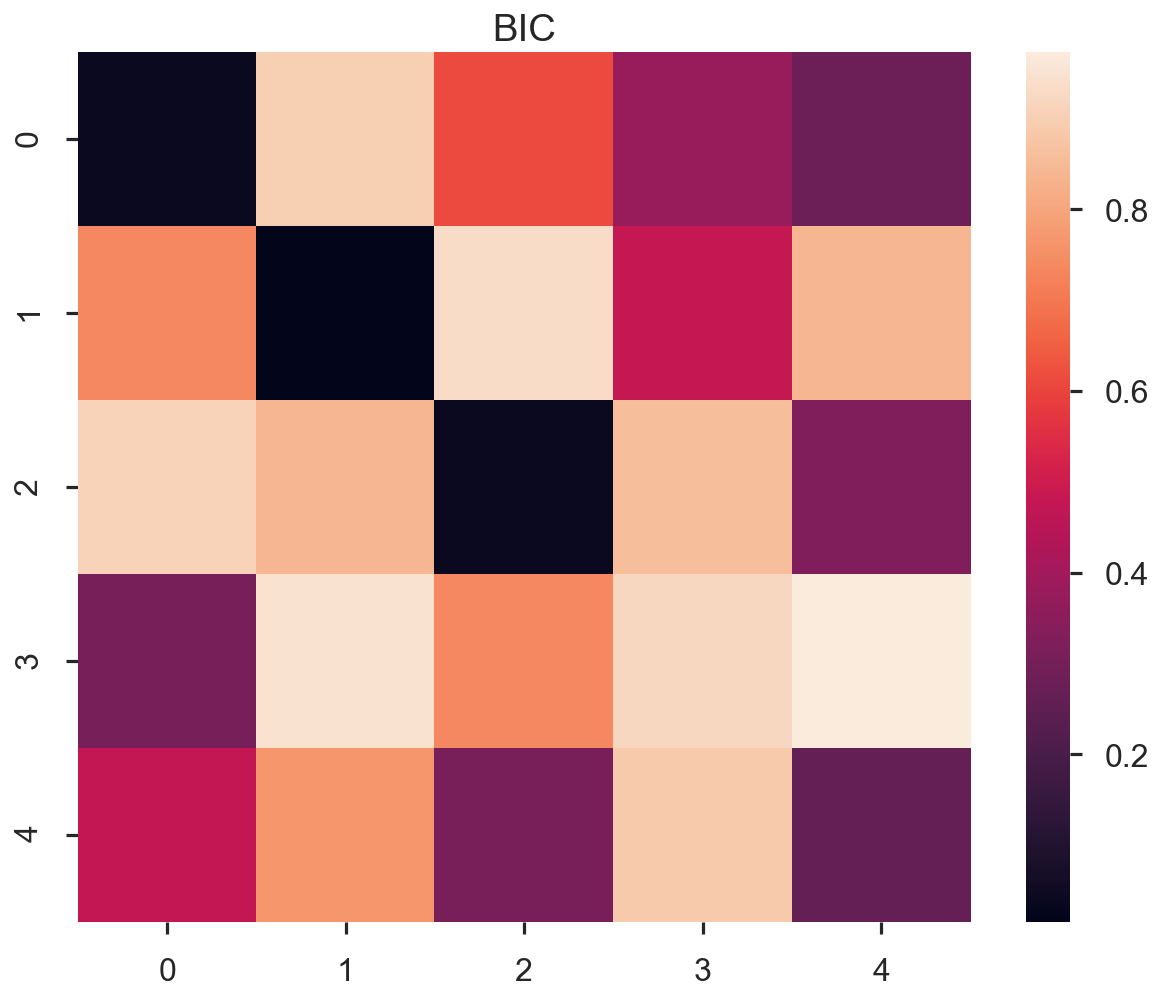

In [49]:
fig, ax=plt.subplots(figsize=(10,8))
print(results_bic)
a=np.random.rand(5,5)
print(a)
ax=sns.heatmap(a)
ax.set_title('BIC')

In [53]:
train_results=sm.tsa.arma_order_select_ic(ts_train,ic=['aic','bic'],
                                        trend='nc',max_ar=4,max_ma=4)
print('AIC',train_results.aic_min_order)
print('BIC',train_results.aic_min_order)

D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:473: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


AIC (2, 2)
BIC (2, 2)


D:\Anaconda3\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


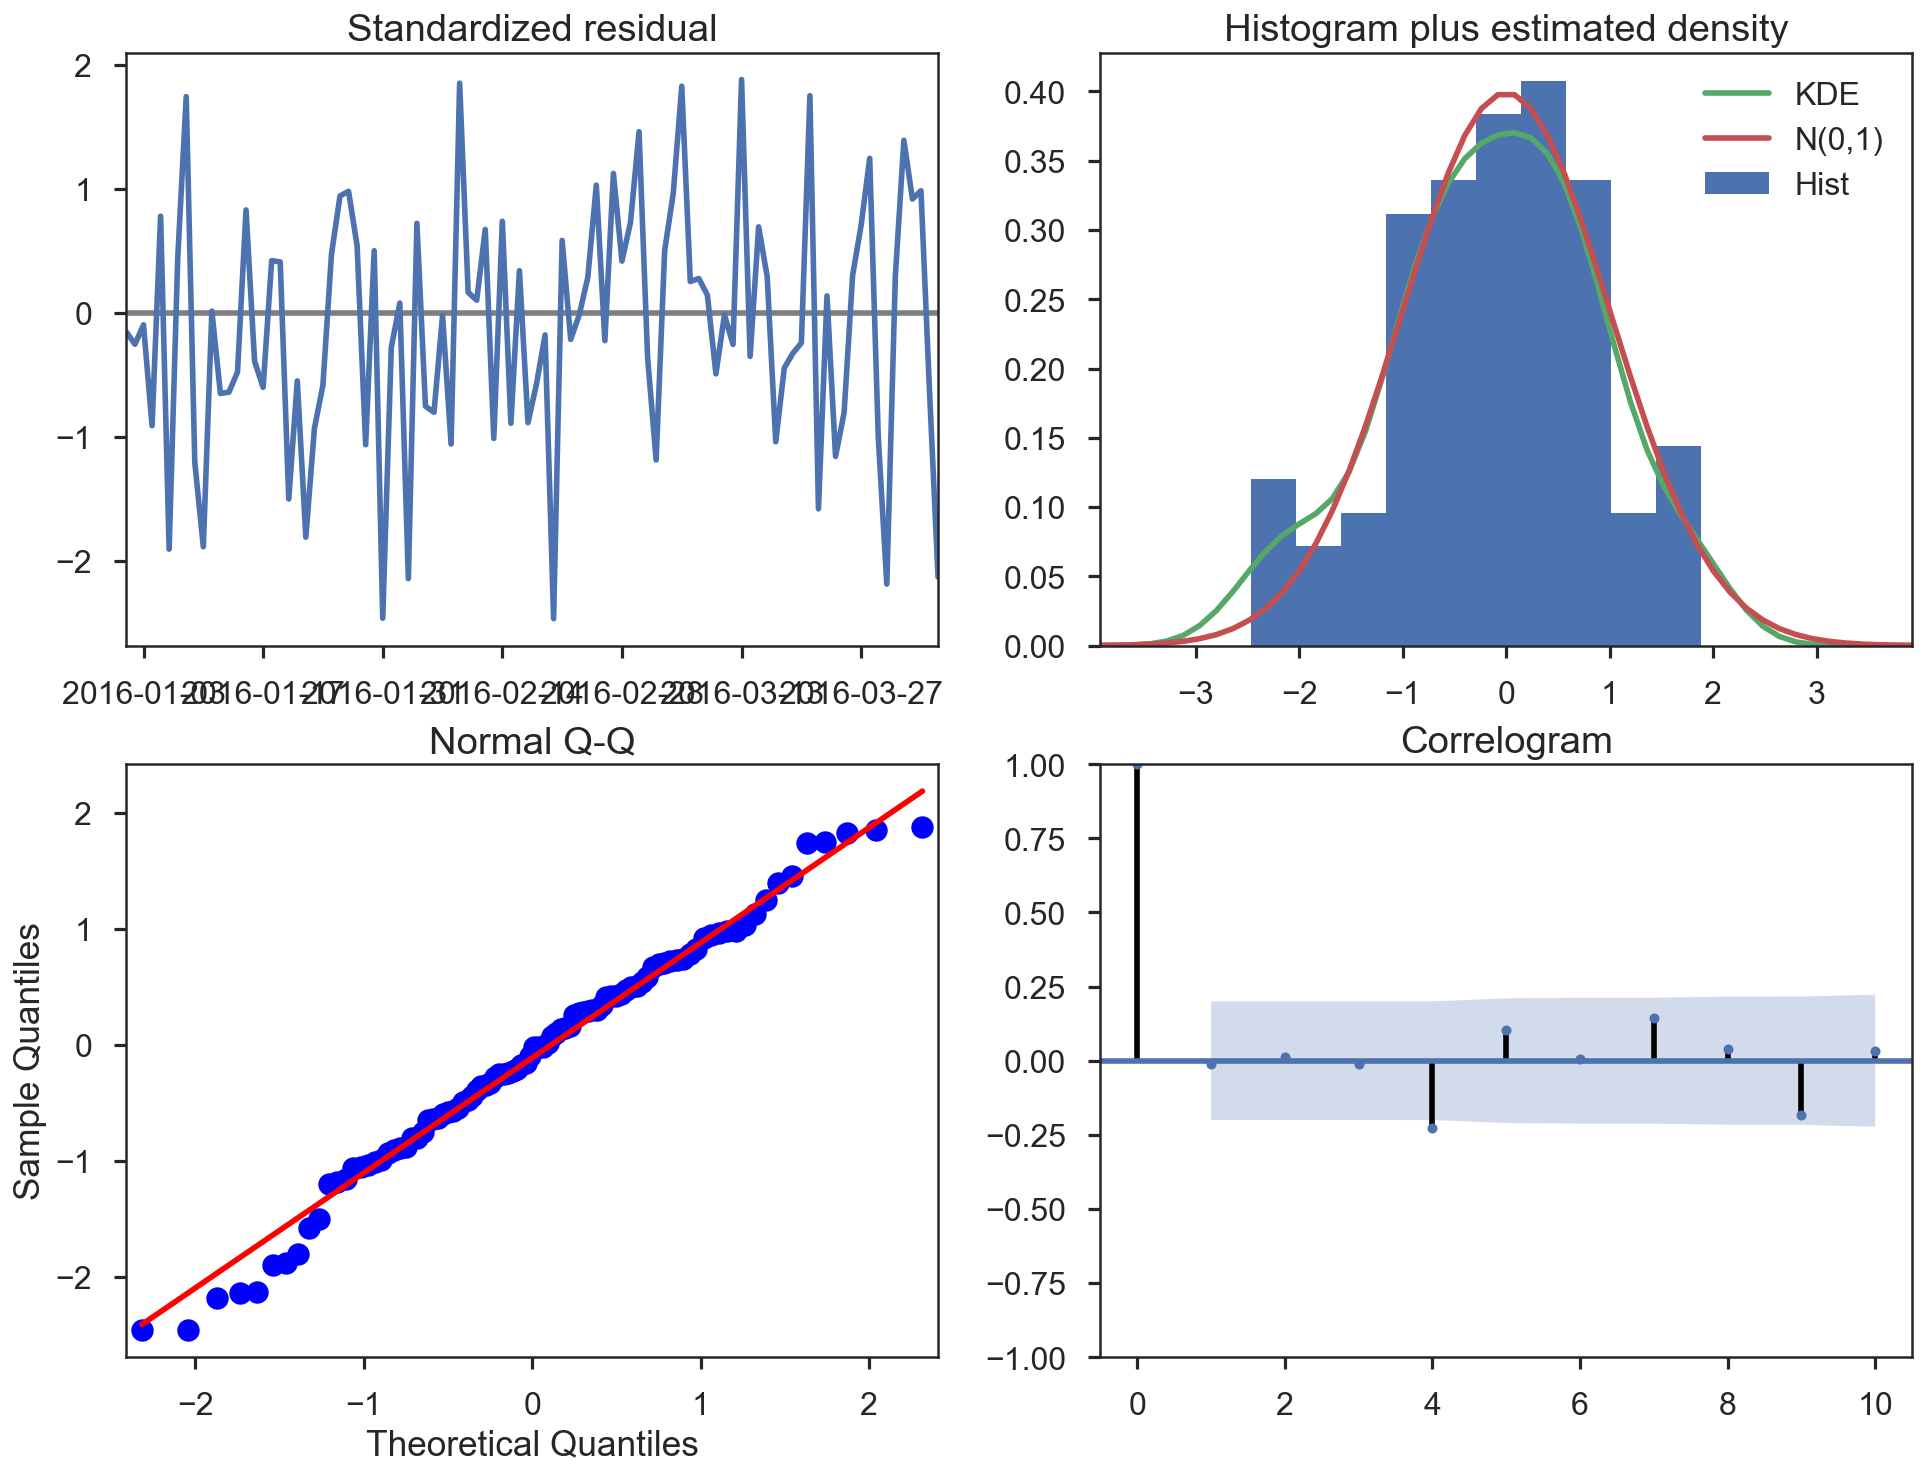

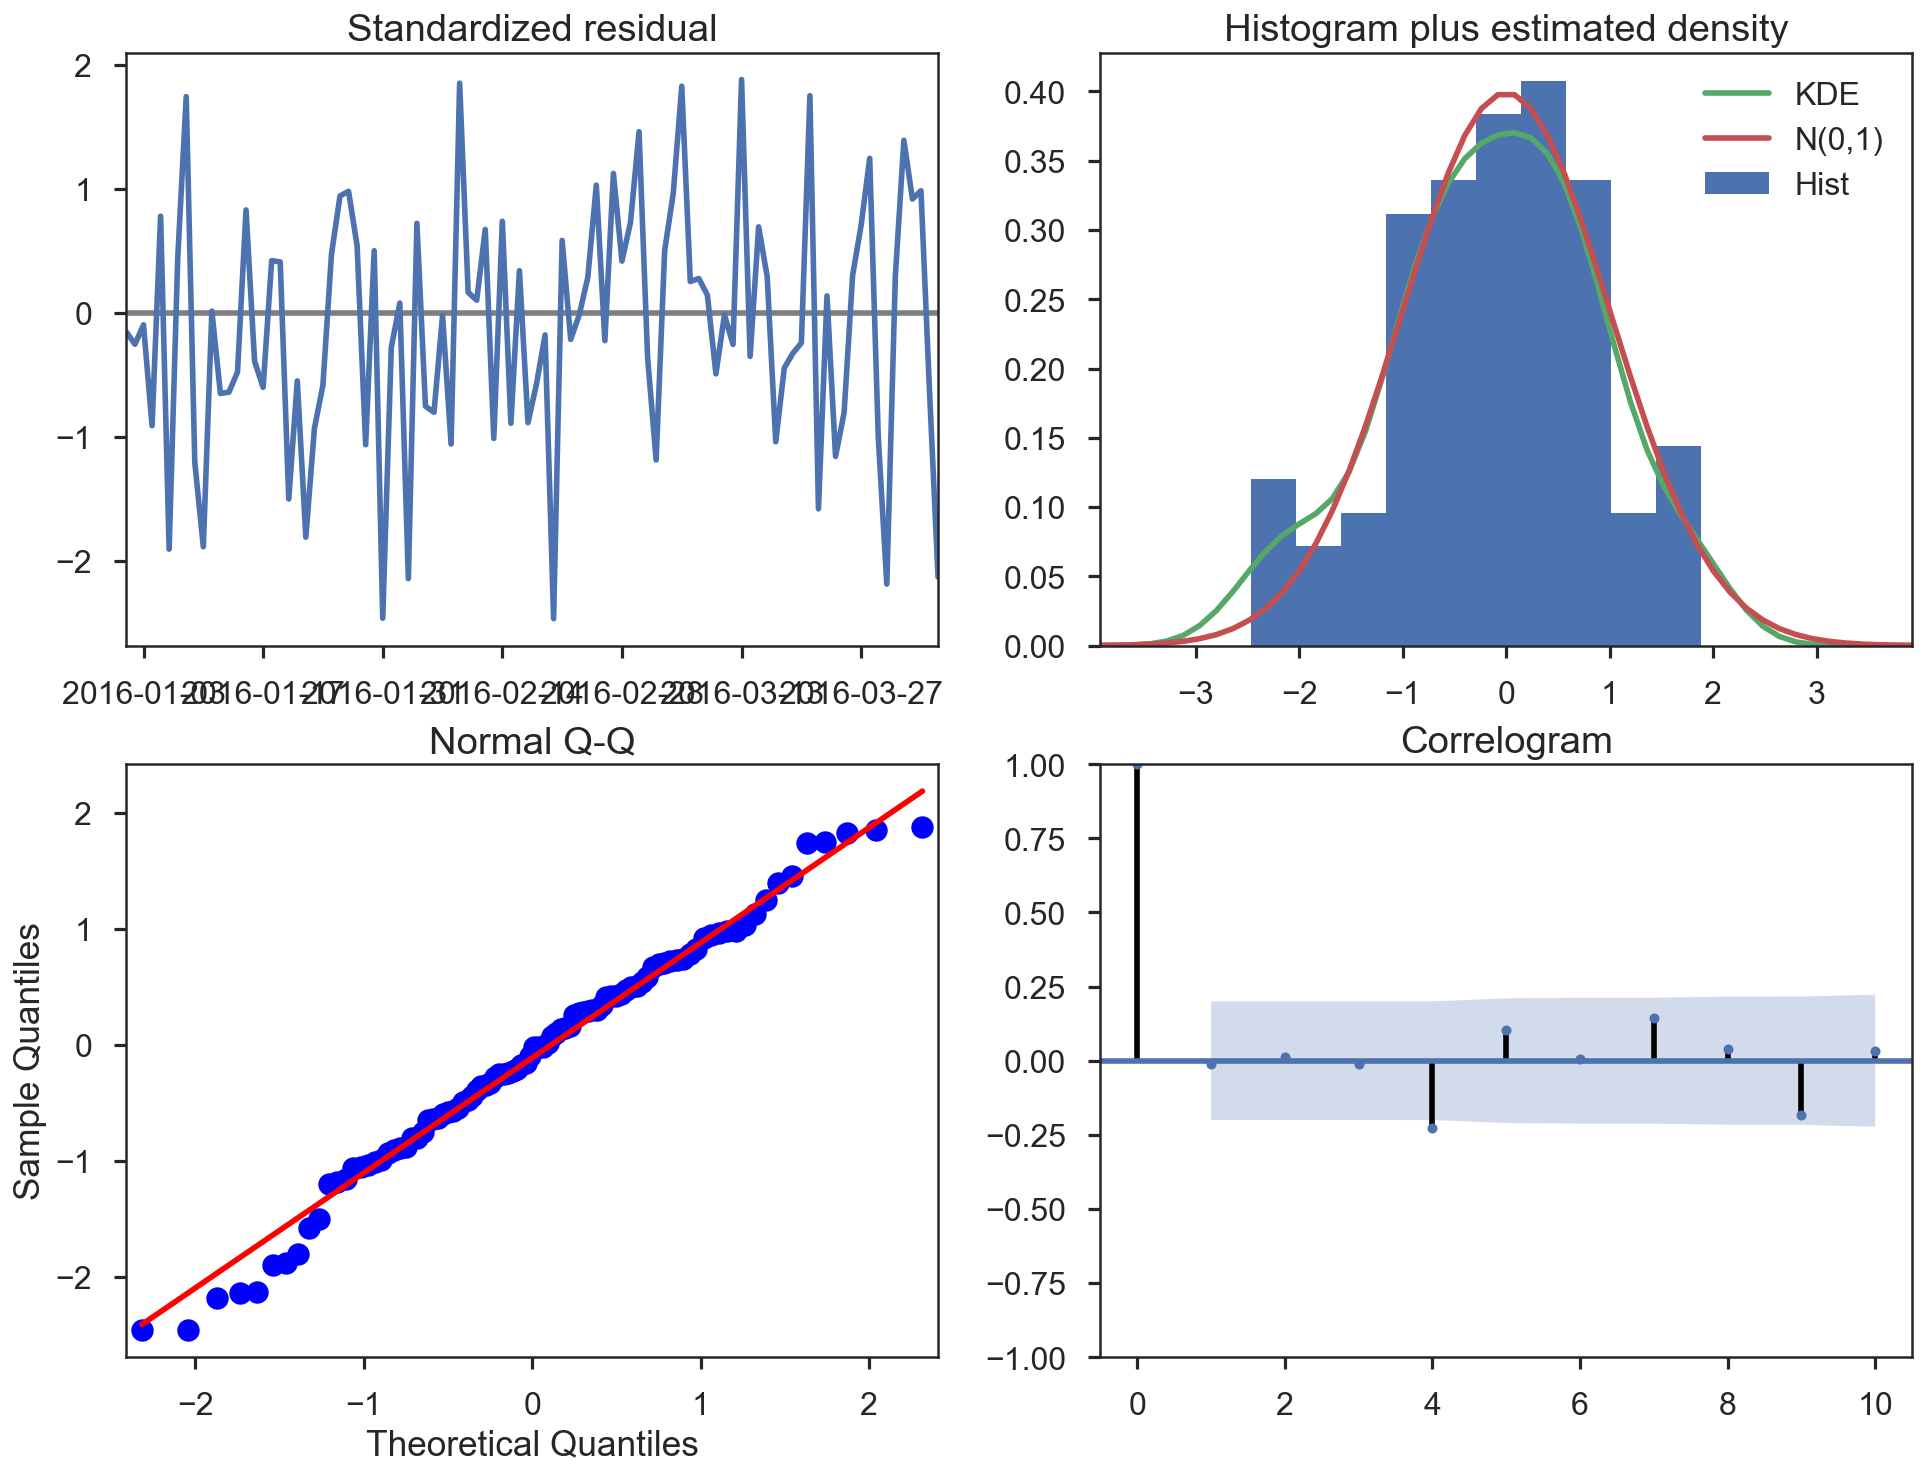

In [56]:
model_results.plot_diagnostics(figsize=(16,12))